🎯 **High-level objective**

Build an interactive agent that:

Ingests property listings, portfolio holdings (tabular), market trends (time-series), and documents (neighborhood reports, regulations).

Indexes textual docs (RAG) and tabular data (structured retrieval + small models).

Lets the user ask investment questions in natural language (e.g., “Should I invest in region X?”, “Show ROI scenarios for Property Y”), and returns:

Data-backed recommendations,

Cited evidence (documents & data),

Workflow actions (generate/download spreadsheet of ROI scenarios, save results to CSV, create a shortlist).

Produces beautiful visualizations (maps, ROI scenario plots, comparators).

Demonstrates safe, auditable automation (tool calls are simulated or produce files the user can download).

## Importing Libraries and Setting Up Client



In [ ]:
#!pip install groq langchain langchain-community langchain-core langchain-groq plotly openpyxl ipywidgets nbformat faiss-cpu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import os
import random
import plotly.express as px
import warnings
import ipywidgets as widgets

from groq import Groq
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import display, HTML
from google.colab import userdata

warnings.filterwarnings('ignore')

#Setting up API KEY
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

client = Groq(api_key=GROQ_API_KEY)

llm = ChatGroq(api_key=GROQ_API_KEY, model = 'llama-3.1-8b-instant')
print('Groq llm successfull!!')

Groq llm successfull!!


FUNCTION: TO Cleanly Call Ai (GROQ- To reuse anywhere)

In [3]:
def ask_groq(query,system_prompt='You are a helpful Ai assistant.'):
  '''Sends a text to Groq and returns the response'''
  messages = [
      SystemMessage(content=system_prompt),
      HumanMessage(content=query)
  ]
  response = llm.invoke(messages)
  return response.content
print('ask_groq() helper function ready!!')

ask_groq() helper function ready!!


### Create Real-Estate Investment DataSet

In [4]:
np.random.seed(42)

regions = [
    'Lahore - Johar Town','Lahore - Gulberg','Lahore - DHA',
    'Karachi - DHA','Karachi - Clifton',
    'Islamabad - F-7','Islamabad - F-10','Islamabad - DHA'
]
num_properties = 50

data = {
    'PropertyID': range(1, num_properties + 1),
    'Region': np.random.choice(regions, num_properties),
    'Price (PKR Millions)': np.random.uniform(12, 120, num_properties).round(2),
    'Annual Rent Yield (%)': np.random.uniform(3.5, 10, num_properties).round(2),
    '5-Year Appreciation (%)': np.random.uniform(8, 60, num_properties).round(2),
    'Risk Score (1=Low, 10=High)': np.random.randint(1, 10, num_properties),
    'Occupancy_Rate (%)': np.random.uniform(65, 98, num_properties).round(2),
}

df_properties = pd.DataFrame(data)

print('Real-estate dataset created successfuly!!')
df_properties.head()

Real-estate dataset created successfuly!!


,PropertyID,Region,Price (PKR Millions),Annual Rent Yield (%),5-Year Appreciation (%),"Risk Score (1=Low, 10=High)",Occupancy_Rate (%)
0,1,Islamabad - F-10,96.80,8.24,30.21,4,70.81
1,2,Karachi - DHA,33.56,8.51,50.54,9,65.60
2,3,Karachi - Clifton,67.54,3.98,52.76,1,81.30
3,4,Islamabad - F-10,75.98,5.83,8.36,8,70.90
4,5,Lahore - DHA,17.02,4.25,34.56,7,77.09


## EDA - Beautiful & Interactive Data Visualizations

### Scatter Plot - Price vs Rent Yield

In [5]:
fig1 = px.scatter(
    df_properties,
    x='Price (PKR Millions)',
    y='Annual Rent Yield (%)',
    color='Region',
    size='Occupancy_Rate (%)',
    hover_data=df_properties.columns,
    title='Price vs Rent Yield (Interactive)'
)
fig1.show()


### Average Appreciation by Region

In [6]:
avg_appreciation = df_properties.groupby('Region')['5-Year Appreciation (%)'].mean().reset_index()

fig2 = px.bar(
    avg_appreciation,
    x='Region',
    y='5-Year Appreciation (%)',
    color='Region',
    title= 'Average Appreciation by Region'
)
fig2.show()

### Heatmap - Correlation Insight

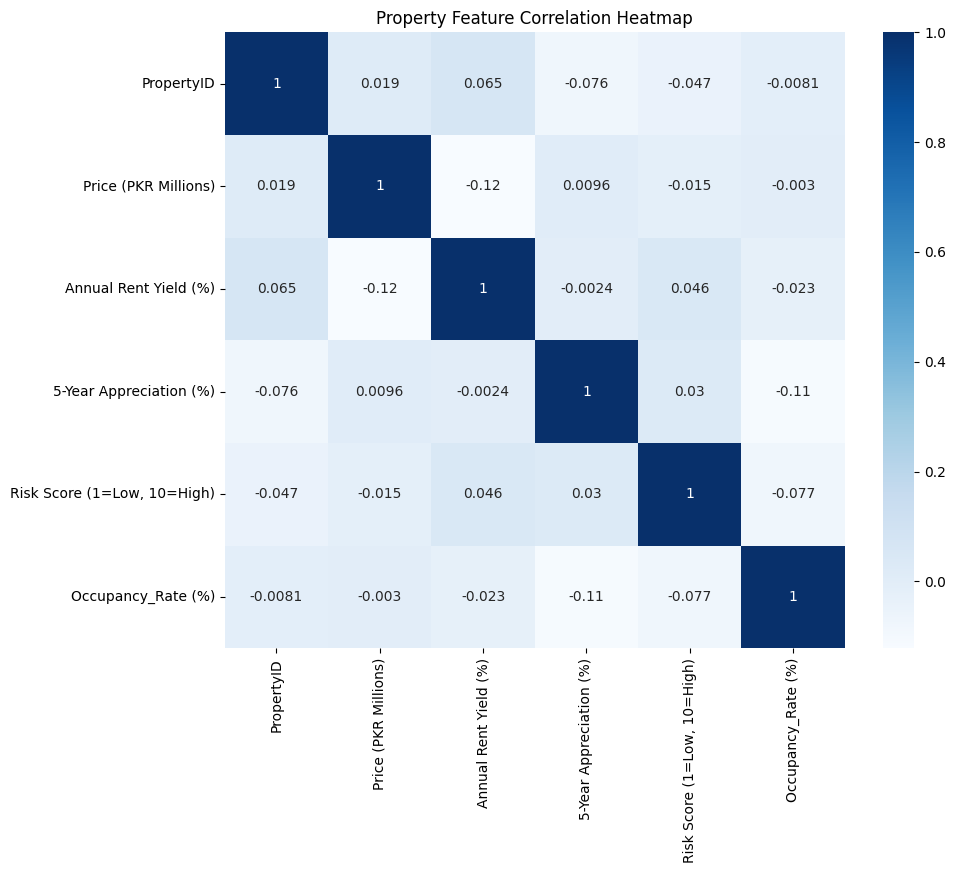

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_properties.corr(numeric_only=True), annot=True,cmap='Blues')
plt.title('Property Feature Correlation Heatmap')
plt.show()

## RAG Embeddings + Vector DataBase

### TEXT + Tabular RAG (Embeddings + Vector DB)

In [8]:
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings

#NOW Convert dataframe rows to text chunks

def row_to_text(row):
  return (
      f'Property ID: {row["PropertyID"]}\n'
      f'Region: {row["Region"]}\n'
      f'Price: {row["Price (PKR Millions)"]}\n'
      f'Annual Rent Yield: {row["Annual Rent Yield (%)"]}%\n'
      f"5-year Appreciation: {row['5-Year Appreciation (%)']}"
      f'Risk Score: {row["Risk Score (1=Low, 10=High)"]}\n'
      f"Occupancy Rate: {row['Occupancy_Rate (%)']}")

property_text_data = [row_to_text(r) for _, r in df_properties.iterrows()]
print('COnverted property table into RAG-ready text chunks!!')

COnverted property table into RAG-ready text chunks!!


### Adding Real-Estate General knowledge

In [9]:
real_estate_knowledge = '''
Real estate investment fundamentals.
- High rent yield areas usually offer stable cash flow.
- High 5-year appreciation regions offer long-term returns.
- Risk score helps measure volatility and market uncertainty.
- Occupancy rate indicates tenant demand.
- Diversification across regions reduces portfolio risk.

Investment guidlines:
- For rental income - prioritize high yield + high occupancy.
- For long-term growth - prioritize high appreciation regions.
- For low-risk investors - avoid areas with risk scove above 7.
- For aggressive investors - balance appreciation with manageable risk.
'''

#Combine all text data
full_text_corpus = property_text_data + [real_estate_knowledge]

#NOW split text into manageable chunks for RAG
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50)
documents = splitter.create_documents(full_text_corpus)
print(f'Prepared {len(documents)} text chunks for vector DB.')

Prepared 52 text chunks for vector DB.


### Create Embeddings (latest HF Embeddings)

In [10]:
from langchain.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')
print('Embedding model loaded successfully!!')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model loaded successfully!!


### Build FAISS vector store

In [11]:
vector_store = FAISS.from_documents(documents, embeddings)
print('Vector store created successfully!!')

Vector store created successfully!!


## Agent Building Process

In [12]:
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

#Connect to Llama-3
def groq_llama(messages):
  response = client.chat.completions.create(
      model = 'llama-3.1-8b-instant',
      messages = messages,
      #api_key = GROQ_API_KEY,
      temperature=0.1
  )
  return response.choices[0].message.content

#print('Groq Llama model connected sucessfully!!')

ret = vector_store.as_retriever(search_kwargs={'k':5})
#print('Retriever is Ready!!')

prompt_template = '''
You are a highly experienced Real-Estate Investment Advisor specializing in:
- rental yield anaysis
- appreciation forecasting
- risk assessment
- ROI modeling
- portfolio strategy

You have access to a vector database containing real estate data and expert knowledge.

When answering:
- Always cite retrieved facts as: (Source:RAG)
- If performing calculations, clearly show steps.
- Provide recommendations, risks and alternatives.
- Never hallucinate numbers; use only retrieved data or computations.

User question:
{question}

Retrieved context from vector DB:
{context}

Provide a polished, professional, industry-level answer.
'''
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=['question', 'context']
)

#NOW create the retrieval QA chain.

def real_estate_agent(query):
  #1 - Retrive context from FAISS
  docs = ret.get_relevant_documents(query)
  context = '\n\n'.join([d.page_content for d in docs])

  #2 Format final structured prompt for GROQ
  messages = [
      {'role':'system','content':'You are a helpful expert real estate advisor.'},
      {'role':'user','content':PROMPT.format(question=query,context=context)}
  ]

  # Call GRoq Ai model Llama
  answer = groq_llama(messages)
  return answer

query = 'Which region gives the best balance between high appreciation and moderation risk?'

response = real_estate_agent(query)
print(response)

Based on the provided data and investment guidelines, I will analyze the regions to determine which one offers the best balance between high appreciation and moderate risk.

**Region 1: Islamabad - F-10**

- Property ID: 42
- Price: 27.22
- Annual Rent Yield: 8.72%
- 5-year Appreciation: 24.68
- Risk Score: 9
- Occupancy Rate: 77.3

This region has a high annual rent yield, indicating stable cash flow. However, the 5-year appreciation rate is moderate, and the risk score is high (9), which may not be suitable for low-risk investors.

**Region 2: Islamabad - F-7**

- Property ID: 27
- Price: 95.71
- Annual Rent Yield: 7.64%
- 5-year Appreciation: 20.46
- Risk Score: 3
- Occupancy Rate: 97.82

This region has a lower annual rent yield compared to F-10 but offers a higher 5-year appreciation rate. The risk score is low (3), making it an attractive option for investors seeking balance between appreciation and risk.

**Region 3: Islamabad - F-10**

- Property ID: 1
- Price: 96.8
- Annual Re

### Real Estate Portfolio ROI Simulator (Tool-Calling)

In [13]:
import math

#Create a ROI Calculator

def calculate_roi(purchase_price, annual_rental_income, annual_expenses, appreciation_rate, years):

  '''
  Simple ROI calculator for real estate investments.
  '''
  #Net income
  net_income = (annual_rental_income - annual_expenses) * years

  #Property appreciation
  future_value = purchase_price * ((1 + appreciation_rate) ** years)
  appreciation_gain = future_value - purchase_price

  #ROI formula
  roi = ((net_income + appreciation_gain) / purchase_price) * 100

  return {
      'Net Income': net_income,
      'Appreciation Gain': appreciation_gain,
      'Future Property Value': future_value,
      'ROI (%)': roi
}

#Rental yield
def rental_yield(monthly_rent, property_price):
  return (monthly_rent*12) / property_price * 100

#Cash flow simulator
def cash_flow_simulator(monthly_rent, monthly_expenses):
  return monthly_rent - monthly_expenses

#Appreciation Projection Table
def appreciation_table(price, annual_rate, years=10):
  data = {'Year':[], 'Estimated Value':[]}
  for year in range(1, years + 1):
    data['Year'].append(year)
    data['Estimated Value'].append(price*((1+annual_rate)**year))
  return pd.DataFrame(data)

#TOol Decision Logic
def decide_and_execute_tool(query):
  q = query.lower()

  if 'roi' in q or 'return on investment' in q:
    return 'ROI'
  if 'rental yield' in q:
    return 'YIELD'
  if 'cash flow' in q:
    return 'CASHFLOW'
  if 'appreciation table' in q or 'projection' in q:
    return 'APPRECIATION'
  return None #Normal RAG analysis

#Agent that combines RAG + Total Calls + LLM Reasoning
def real_estate_super_agent(query):
  tool = decide_and_execute_tool(query)

  #Case 1: Tool needs to run
  if tool == 'ROI':
    #Extract numbers using LLM first
    extract_msg = [
        {'role':'system','content':'Extract numbers from the user query.'},
        {'role':'user','content':f"Extract all numeric values from this message: {query}"},
    ]
    numbers = groq_llama(extract_msg)
    return f"ROI tool was triggered!\n\nExtracted numbers:\n{numbers}\n\nNow plug values into calculator."
  if tool == 'YIELD':
    return 'Rental Yield tool triggered! Please provide: monthly rent & property price.'
  if tool == 'CASHFLOW':
    return 'Cash Flow tool triggered! Please provide: monthly rent & monthly expenses.'
  if tool == 'APPRECIATION':
    return 'Appreciation table tool triggered! Please provide: price and annual appreciation rate'

#Case 2: Normal RAG + LLM answer
  return real_estate_agent(query)

print('ROI Tool + Multi-Function Investment Agent Ready!!')


# Interactive ROI Scenario Builder & Excel Exporter

import io
import plotly.graph_objects as go
from IPython.display import Markdown # Import Markdown

#optional Colab download helper
try:
  from google.colab import files as colab_files
  IS_COLAB = True
except Exception:
  IS_COLAB = False

OUTPUT_DIR = 'outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

#HELPER financial functions
def npv(cashflows, discount_rate):
  '''Compute NPV given a sequence of cashflows (t=0..n) and annual discount rate (as decimal).'''
  return sum(cf / ((1 + discount_rate) ** t) for t, cf in enumerate(cashflows))

def irr(cashflows):
  '''Compute IRR via numpy. Returns a decimal(e.g., 0.12 for 12%).'''
  try:
    return np.irr(cashflows)
  except Exception:
    return None

def calc_roi_scenarios_for_property(prop_row, scenarios, years=10, discount_rate=0.10):
  '''
  prop_now: pandas series representing a property
  scenarios: list of dicts each with keys: rent_growth, appreciation_rate, vacancy_rate, expense_pct
  returns: DataFrame of scenario results(per-year cash flows and summary metrics)
  '''
  results = []
  purchase_price = float(prop_row['Price (PKR Millions)']) * 1e6 #Convert to PKR
  base_rent_yield = float(prop_row['Annual Rent Yield (%)']) / 100.0
  base_annual_rent = purchase_price * base_rent_yield

  for i, sc in enumerate(scenarios):
    rent_growth = sc.get('rent_growth',0.0)
    appreciation = sc.get('appreciation_rate',0.0)
    vacancy = sc.get('vacancy_rate',0.05)
    expense_pct = sc.get('expense_pct',0.3)

    yearly_cashflows = []
    df_years = {'Year':[], 'Rent (Gross)':[], 'Vacancy Loss': [], 'Expenses':[], 'Net Cashflow':[],'Est. Value':[]}
    current_rent = base_annual_rent

    for y in range(1, years + 1):
      #grow rent
      current_rent = current_rent * (1 + rent_growth)

      #vacancy loss
      vacancy_loss = current_rent * vacancy

      expenses = current_rent * expense_pct
      net = current_rent - vacancy_loss - expenses

      value = purchase_price * ((1 + appreciation) ** y)

      df_years['Year'].append(y)
      df_years['Rent (Gross)'].append(round(vacancy_loss,2))
      df_years['Vacancy Loss'].append(round(vacancy_loss,2))
      df_years['Expenses'].append(round(expenses,2))
      df_years['Net Cashflow'].append(round(net,2))
      df_years['Est. Value'].append(round(value,2))

      yearly_cashflows.append(net)

    #Now build summary metrics
    initial_outflow = -purchase_price
    cashflow_series = [initial_outflow] + yearly_cashflows
    computed_npv = npv(cashflow_series, discount_rate)
    computed_irr = irr(cashflow_series)

    results.append({
        'scenario_id': f'scenario_{i+1}',
        'rent_growth': rent_growth,
        'appreciation':appreciation,
        'vacancy': vacancy,
        'expense_pct': expense_pct,
        'npv': computed_npv,
        'irr': computed_irr if computed_irr is not None else float('nan'),
        'years_table': pd.DataFrame(df_years)
    })
  return results


#UI widgets
prop_options = [f'{int(r['PropertyID'])} - {r['Region']} - PKR {r['Price (PKR Millions)']}M' for _, r in df_properties.iterrows()]
prop_select = widgets.SelectMultiple(
    options=prop_options,
    rows=8,
    description='Properties',
    layout=widgets.Layout(width='55%')

)

#Scenario inputs - we support uoto 3 scenarios
scenario_boxes = []

for i in range(3):
  rent_g = widgets.FloatText(value=0.3, description=f'Rent Growth {i+1}',step=0.01)
  appr = widgets.FloatText(value=0.05, description=f'Appreciation {i+1}',step=0.01)
  vac = widgets.FloatText(value=0.05, description=f'Vacancy {i+1}',step=0.01)
  expense_pct = widgets.FloatText(value=0.30, description=f'Expense % {i+1}',step=0.0)
  scenario_boxes.append((rent_g,appr,vac,expense_pct))

years_widget = widgets.IntSlider(value=10, min=3, max=30, step=1, description='Years')
discount_widget = widgets.FloatSlider(value=0.10, min=0.01, max=0.25, step=0.005, description='Discount')

generate_button = widgets.Button(description='Generate ROI Spreadsheet', button_style='success')
output_area = widgets.Output(layout={'border': '1px solid gray'})

#Excel generator
def generate_roi_spreadsheet(property_ids, scenario_defs, years=10, discount=0.10, filename=None):
  '''
  property_ids: list of integer property IDs (1-based)
  scenario_defs: list of dicts with keys: rent_growth, appreciation_rate, vacancy_rate, expense_pct
  returns path to saved file
  '''

  if not filename:
    filename = f'{OUTPUT_DIR}/roi_scenario_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.xlsx'
  writer = pd.ExcelWriter(filename, engine='openpyxl')

  summary_rows = []
  for pid in property_ids:
    prop_row = df_properties[df_properties['PropertyID'] == pid].iloc[0]
    results = calc_roi_scenarios_for_property(prop_row,scenario_defs, years, discount_rate=discount)
    #results is a list of dict (same structure as earlier function)
    for res in results:
      sid = res['scenario_id']
      #write the per-year table
      sheet_name = f'P{pid}_{sid}'
      res['years_table'].to_excel(writer, sheet_name=sheet_name, index=False)
      #add to summary
      summary_rows.append({
          'Property ID': pid,
          'Property Region': prop_row['Region'],
          'Scenario': sid,
          'Rent Growth %': res['rent_growth']*100,
          'Appreciation %': res['appreciation']*100,
          'Vacancy %': res['vacancy']*100,
          'Expense %': res['expense_pct']*100,
          'NPV': res['npv'],
          'IRR': res['irr']
      })
  df_summary = pd.DataFrame(summary_rows)
  df_summary.to_excel(writer, sheet_name='Summary', index=False)
  writer.close() # Use writer.close() instead of writer.save() for newer openpyxl versions
  return filename, df_summary


#Button handler
def on_generate_clicked(b):
  with output_area:
    output_area.clear_output()
    display(Markdown('### Running ROI Scenario Generation...'))
    selected = list(prop_select.value)
    if not selected:
      print('Please select at least one property')
      return
    #parse property ids
    selected_ids = [int(s.split(' - ')[0]) for s in selected]

    #build scenario defs
    scenario_defs = []
    for rent_g, appr, vac, exp_pct in scenario_boxes:
      scenario_defs.append({
          'rent_growth': float(rent_g.value),
          'appreciation_rate': float(appr.value),
          'vacancy_rate': float(vac.value),
          'expense_pct': float(exp_pct.value)
      })
    #remove duplicate identical scenarios (optional) and empty
    # scenario_defs = scenario_defs #keep as-is for now
    # Filter out scenarios where all parameters are 0 or empty, indicating they weren't explicitly set
    scenario_defs = [s for s in scenario_defs if any(val != 0.0 for val in s.values())]
    if not scenario_defs:
        print('Please define at least one scenario.')
        return

    years = int(years_widget.value)
    discount = float(discount_widget.value)

    display(Markdown(f'- Properties selected: {selected_ids}'))
    display(Markdown(f'- Years: {years} | Discount rate: {discount:.2%}'))
    display(Markdown(f'- Running {len(scenario_defs)} scenarios per property...'))

    filename, df_summary = generate_roi_spreadsheet(selected_ids, scenario_defs, years=years, discount=discount)

    display(Markdown(f'- Spreadsheet generated: `{filename}`'))
    display(Markdown(f'### Summary of scenario results:'))
    display(df_summary.style.format({'NPV': '{:,.0f}', 'IRR': '{:.2%}'}))

    #provide download link(colab) or file path (Kaggle)
    if IS_COLAB:
      try:
        display(Markdown('Click the link below to download the spreadsheet: '))
        colab_files.download(filename)
      except Exception as e:
        display(Markdown(f'Could not download file: {e}). File saved at `{filename}`'))

    else:
      display(Markdown(f'Download not auto-enabled in this environment. File saved at `{filename}`'))

generate_button.on_click(on_generate_clicked)

#LAyout and display
left_col = widgets.VBox([widgets.Label('Select Properties (multi-select)'), prop_select, generate_button])
scenario_widgets = []
for i, (rent_g, appr, vac, exp_pct) in enumerate(scenario_boxes, start=1):
  scenario_widgets.append(widgets.HBox([rent_g, appr, vac, exp_pct]))

right_col = widgets.VBox([
    widgets.Label('Scenarios (adjust parameters per scenario)'),
    *scenario_widgets,
    years_widget,
    discount_widget
])

ui = widgets.HBox([left_col, right_col])
display(Markdown('## ROI scenario builder & excel exporter'))
display(Markdown('Select properties, tune scenarios and click Generate ROI Spreadsheet.'))
display(ui)
display(output_area)

ROI Tool + Multi-Function Investment Agent Ready!!


## ROI scenario builder & excel exporter

Select properties, tune scenarios and click Generate ROI Spreadsheet.

Output(layout=Layout(border='1px solid gray'))

## Advanced Visualizations for ROI Scenarios

In [16]:
# ============================================================
# Ÿ CELL 9 — Advanced ROI Scenario Visualizations (Plotly)
# ============================================================

import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, Markdown

def visualize_property_scenarios(property_ids, scenario_defs, years=10, discount_rate=0.10):
    display(Markdown("## Ÿ ROI Scenario Visualizations"))
    display(Markdown(f"### Selected Properties → {property_ids}"))
    display(Markdown("---"))

    all_summary_rows = []

    for pid in property_ids:
        # FIX: Changed 'Property ID' to 'PropertyID' to match the DataFrame column name.
        prop_row = df_properties[df_properties["PropertyID"] == pid].iloc[0]
        display(Markdown(f"## Ÿ Property {pid} — {prop_row['Region']} (PKR {prop_row['Price (PKR Millions)']}M)"))

        results = calc_roi_scenarios_for_property(
            prop_row,
            scenario_defs,
            years=years,
            discount_rate=discount_rate
        )

        # ---- 1) CASHFLOW LINE CHART ----
        fig_cf = go.Figure()
        for res in results:
            df_years = res["years_table"]
            fig_cf.add_trace(go.Scatter(
                x=df_years["Year"],
                y=df_years["Net Cashflow"],
                mode="lines+markers",
                name=f"{res['scenario_id']} (RentGrow={res['rent_growth']*100:.1f}%)"
            ))
        fig_cf.update_layout(
            title=f"Ÿ Net Cashflow Over Time — Property {pid}",
            xaxis_title="Year",
            yaxis_title="Net Cashflow (PKR)",
            template="plotly_white"
        )
        fig_cf.show()

        # ---- 2) PROPERTY VALUE APPRECIATION ----
        fig_val = go.Figure()
        for res in results:
            df_years = res["years_table"]
            fig_val.add_trace(go.Scatter(
                x=df_years["Year"],
                y=df_years["Est. Value"],
                mode="lines",
                name=f"{res['scenario_id']} (Appr={res['appreciation']*100:.1f}%)"
            ))
        fig_val.update_layout(
            title=f"Ÿ Property Value Appreciation — Property {pid}",
            xaxis_title="Year",
            yaxis_title="Estimated Value (PKR)",
            template="plotly_white"
        )
        fig_val.show()

        # ---- 3) STACKED EXPENSE / VACANCY AREA CHART ----
        fig_stack = go.Figure()
        df_years = results[0]["years_table"]  # same years for all scenarios

        for res in results:
            df = res["years_table"]
            fig_stack.add_trace(go.Scatter(
                x=df["Year"], y=df["Vacancy Loss"], stackgroup='one', name=f"{res['scenario_id']} Vacancy"
            ))
            fig_stack.add_trace(go.Scatter(
                x=df["Year"], y=df["Expenses"], stackgroup='one', name=f"{res['scenario_id']} Expenses"
            ))

        fig_stack.update_layout(
            title=f"Ÿ Vacancy Loss + Expenses (Stacked) — Property {pid}",
            xaxis_title="Year",
            yaxis_title="Amount (PKR)",
            template="plotly_white"
        )
        fig_stack.show()

        # ---- COLLECT SUMMARY FOR GLOBAL COMPARISON ----
        for res in results:
            all_summary_rows.append({
                "Property ID": pid,
                "Scenario": res["scenario_id"],
                "NPV": res["npv"],
                "IRR": res["irr"]
            })

        display(Markdown("---"))

    # --------------------------------------------------
    # Ÿ GLOBAL COMPARISON ACROSS ALL PROPERTIES
    # --------------------------------------------------
    summary_df = pd.DataFrame(all_summary_rows)
    display(Markdown("## Ÿ Global Scenario Comparison (All Selected Properties)"))

    # ---- 4) NPV COMPARISON ----
    fig_npv = px.bar(
        summary_df,
        x="Scenario",
        y="NPV",
        color="Property ID",
        title="Ÿ NPV Comparison Across Properties",
        barmode="group",
        text_auto=".2s"
    )
    fig_npv.update_layout(template="plotly_white")
    fig_npv.show()

    # ---- 5) IRR COMPARISON ----
    fig_irr = px.bar(
        summary_df,
        x="Scenario",
        y="IRR",
        color="Property ID",
        title="Ÿ IRR Comparison Across Properties",
        barmode="group",
        text_auto=".2%"
    )
    fig_irr.update_layout(template="plotly_white")
    fig_irr.show()

    display(Markdown("### Ÿ Visualizations generated successfully!"))

# ------------------------------------------------------------
# Helper UI runner
# ------------------------------------------------------------
def run_visualizations():
    selected = list(prop_select.value)
    if not selected:
        print("\u26a0 Please select properties first.")
        return

    selected_ids = [int(s.split(" - ")[0]) for s in selected]

    # read scenarios from UI boxes
    scenario_defs = []
    for rent_g, appr, vac, exp_pct in scenario_boxes:
        scenario_defs.append({
            "rent_growth": float(rent_g.value),
            "appreciation_rate": float(appr.value),
            "vacancy_rate": float(vac.value),
            "expense_pct": float(exp_pct.value)
        })

    visualize_property_scenarios(
        property_ids=selected_ids,
        scenario_defs=scenario_defs,
        years=int(years_widget.value),
        discount_rate=float(discount_widget.value)
    )

# Display a button to run visualizations
vis_button = widgets.Button(
    description="Generate All Visualizations",
    button_style="info",
    layout=widgets.Layout(width="250px")
)
vis_button.on_click(lambda b: run_visualizations())

display(Markdown("## Ÿ Generate Property ROI Visualizations"))
display(vis_button)

## Ÿ Generate Property ROI Visualizations

Button(button_style='info', description='Generate All Visualizations', layout=Layout(width='250px'), style=But…

## Ÿ ROI Scenario Visualizations

### Selected Properties → [5]

---

## Ÿ Property 5 — Lahore - DHA (PKR 17.02M)

---

## Ÿ Global Scenario Comparison (All Selected Properties)

### Ÿ Visualizations generated successfully!